<a href="https://colab.research.google.com/github/poolkit/Image-2-Text/blob/main/img2txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Downloading the dataset

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
  
od.download("https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset/download?datasetVersionNumber=1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: poolkit
Your Kaggle Key: ··········


100%|██████████| 8.16G/8.16G [00:56<00:00, 155MB/s]


### Exploring the data

In [3]:
import os
len(os.listdir("/content/flickr-image-dataset/flickr30k_images/flickr30k_images"))

31785

In [4]:
import pandas as pd
import numpy as np

caption = pd.read_csv("/content/flickr-image-dataset/flickr30k_images/results.csv",delimiter='|')
print(caption.shape)
caption.head()

(158915, 3)


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
caption.rename(columns={' comment_number': 'comment_number',
                   ' comment': 'comment'},inplace=True, errors='raise')

In [6]:
col = caption.columns
for each in col:
  caption[each] = caption[each].str.strip()

In [7]:
caption.isnull().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

In [8]:
caption.dropna(inplace=True)

In [9]:
import re

def clean_text(text):
  text = text.lower()
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r" 'bout", " about", text)
  text = re.sub(r"gonna", "going to", text)
  text = re.sub(r"gotta", "got to", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub(r"-"," ",text)
  return text

In [10]:
caption['comment'] = caption['comment'].apply(clean_text)

In [11]:
caption.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,two friends enjoy time spent together .


### Text Processing

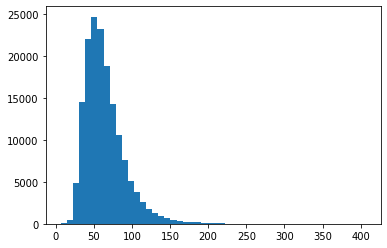

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

word_lengths = list(caption.comment.str.len().astype('Int64'))

plt.hist(word_lengths, bins=50)
plt.show()

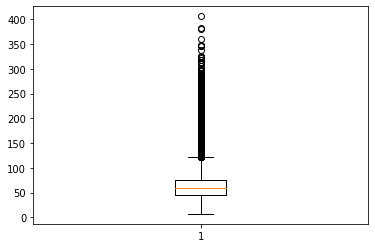

In [13]:
plt.boxplot(word_lengths)
plt.show()

In [14]:
caption['total_length'] = word_lengths

In [15]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
def tokenize_with_tag(text):
  text = word_tokenize(text)
  text.insert(0,'<START>')
  text.append('<END>')
  return text

In [17]:
caption['tokenize'] = caption['comment'].apply(tokenize_with_tag)

In [18]:
caption['word_count'] = caption['tokenize'].str.len()

In [19]:
caption.head()

,image_name,comment_number,comment,total_length,tokenize,word_count
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9


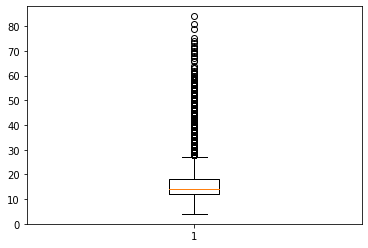

In [20]:
plt.boxplot(caption['word_count'])
plt.show()

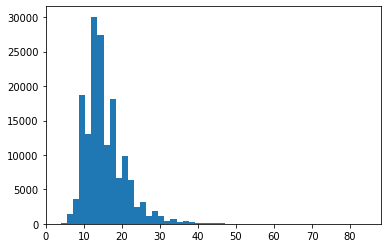

In [21]:
plt.hist(caption['word_count'], bins=50)
plt.show()

In [22]:
caption[caption['word_count']>32].groupby('image_name')['comment_number'].count().sort_values(ascending=False)

image_name
7972860508.jpg    4
7438195398.jpg    4
1150429218.jpg    3
1680674943.jpg    3
3370055006.jpg    3
                 ..
3539960792.jpg    1
3539422395.jpg    1
3538719941.jpg    1
3530843182.jpg    1
991459823.jpg     1
Name: comment_number, Length: 1908, dtype: int64

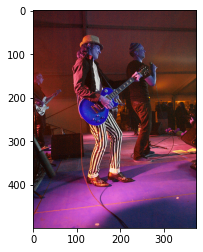

In [23]:
import cv2
img = cv2.imread('/content/flickr-image-dataset/flickr30k_images/flickr30k_images/7438195398.jpg')
plt.imshow(img)

In [24]:
caption[caption['image_name']=='7438195398.jpg']['comment']

151145    three musicians on a stage , two are guitarist...
151146    a man wearing striped pants and a black and wh...
151147    a man in a black jacket and checkered hat wear...
151148    a rock band playing on stage with the lead gui...
151149    at a rock concert a man dressed in black and w...
Name: comment, dtype: object

In [25]:
max_length = 32
df = caption[caption['word_count']<=max_length]

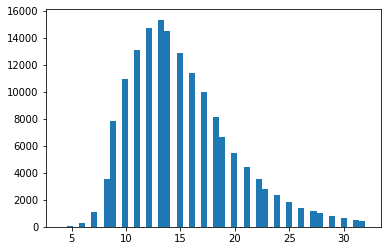

In [26]:
plt.hist(df['word_count'], bins=50)
plt.show()

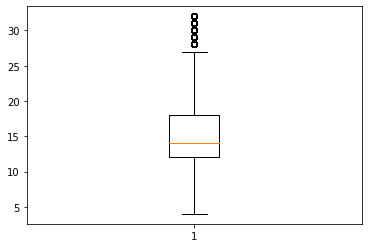

In [27]:
plt.boxplot(df['word_count'])
plt.show()

In [28]:
df.head()

,image_name,comment_number,comment,total_length,tokenize,word_count
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9


In [29]:
caption.shape, df.shape

((158914, 6), (156873, 6))

In [30]:
sentences = []

for each in df['tokenize']:
  sentences.append(each)
                   
sentences[0]

['<START>',
 'two',
 'young',
 'guys',
 'with',
 'shaggy',
 'hair',
 'look',
 'at',
 'their',
 'hands',
 'while',
 'hanging',
 'out',
 'in',
 'the',
 'yard',
 '.',
 '<END>']

In [31]:
vocab_column = df['tokenize']
vocab_dict = {}

for each in vocab_column:
  for i in each:
    if i in vocab_dict:
      vocab_dict[i] += 1
    else:
      vocab_dict[i] = 1

In [32]:
import gensim

w2v_model = gensim.models.Word2Vec(sentences=sentences,size=300,window=10,min_count=1)
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(13257561, 23756470)

In [33]:
gensim.__version__

'3.6.0'

In [34]:
print(f"Total number of words are {len(w2v_model.wv.vocab)}")

Total number of words are 18081


In [35]:
w2v_model.wv.most_similar('woman')

[('lady', 0.8301007747650146),
 ('girl', 0.6621009111404419),
 ('purse', 0.5244199633598328),
 ('female', 0.5196900963783264),
 ('floral', 0.505615234375),
 ('person', 0.49435460567474365),
 ('women', 0.47986382246017456),
 ('flower', 0.47112512588500977),
 ('man', 0.4679524898529053),
 ('bride', 0.45479995012283325)]

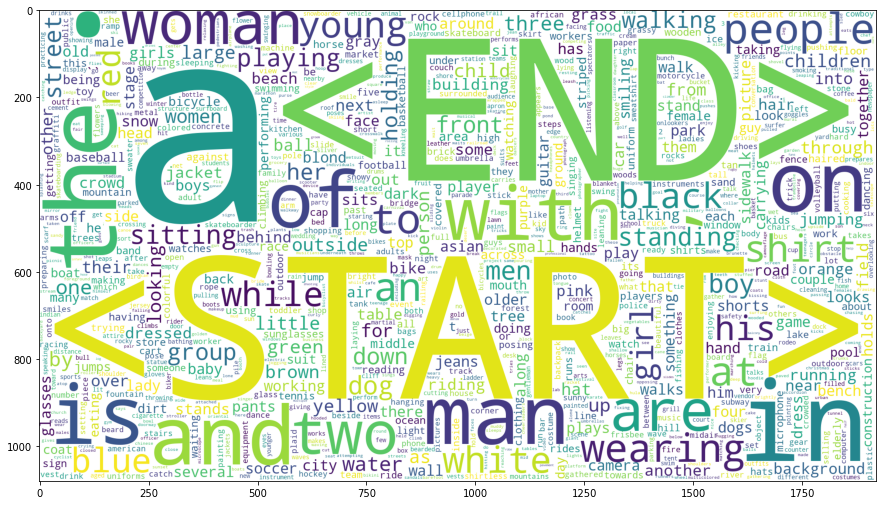

In [36]:
from wordcloud import WordCloud
plt.figure(figsize=(15,20))
wc = WordCloud(background_color="white",width=1920, height=1080, max_words=1000).generate_from_frequencies(vocab_dict)
plt.imshow(wc)
plt.show()

In [37]:
vocab = list(vocab_dict.keys())
vocab_length = len(vocab)

In [38]:
# create embedding matrix

embed_dim = 300
embed_matrix=np.zeros(shape=(vocab_length,embed_dim))
for i,word in enumerate(vocab):
  if word == '<END>':
    embed_matrix[i]=np.zeros(embed_dim)
  else:
    embed_vector=w2v_model.wv.get_vector(word)
    embed_matrix[i]=embed_vector

In [39]:
np.shape(embed_matrix)

(18081, 300)

In [40]:
vocab_length

18081

In [41]:
word_to_id = {}
id_to_word = {}

for i,each in enumerate(vocab):
  word_to_id[each] = i
  id_to_word[i] = each

In [42]:
df.head()

,image_name,comment_number,comment,total_length,tokenize,word_count
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9


In [43]:
df.tail()

,image_name,comment_number,comment,total_length,tokenize,word_count
158910,998845445.jpg,0,a man in shorts and a hawaiian shirt leans ove...,117,"[<START>, a, man, in, shorts, and, a, hawaiian...",27
158911,998845445.jpg,1,"a young man hanging over the side of a boat , ...",105,"[<START>, a, young, man, hanging, over, the, s...",27
158912,998845445.jpg,2,a man is leaning off of the side of a blue and...,89,"[<START>, a, man, is, leaning, off, of, the, s...",25
158913,998845445.jpg,3,"a man riding a small boat in a harbor , with f...",82,"[<START>, a, man, riding, a, small, boat, in, ...",20
158914,998845445.jpg,4,a man on a moored blue and white boat with hil...,77,"[<START>, a, man, on, a, moored, blue, and, wh...",19


In [44]:
one_hot_sentences = []
max_length = 0

for each in sentences:
  temp = []
  for i in each:
    temp.append(word_to_id[i])

  if len(temp)>max_length:
    max_length = len(temp)

  one_hot_sentences.append(temp)

print(f"max length: {max_length}")
one_hot_sentences[:5]

max length: 32


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18],
 [0, 1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17, 18],
 [0, 31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17, 18],
 [0, 1, 36, 37, 38, 39, 40, 17, 18]]

In [45]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
padded_one_hot = pad_sequences(one_hot_sentences, maxlen=max_length, padding='post')

In [47]:
np.shape(padded_one_hot)

(156873, 32)

In [48]:
df.shape

(156873, 6)

In [49]:
decoder_answers = []

for each in padded_one_hot:
  decoder_answers.append(each[1:])

decoder_answers = pad_sequences(decoder_answers, maxlen=max_length, padding='post')

In [50]:
df['padded_one_hot'] = list(padded_one_hot)
df['decoder_answers'] = list(decoder_answers)

<ipython-input-50-85f997ac2ffb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['padded_one_hot'] = list(padded_one_hot)
<ipython-input-50-85f997ac2ffb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decoder_answers'] = list(decoder_answers)


In [51]:
df.head()

,image_name,comment_number,comment,total_length,tokenize,word_count,padded_one_hot,decoder_answers
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13,"[0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, ...","[1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18,..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13,"[0, 1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17,...","[1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17, 18..."
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13,"[0, 31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17...","[31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17, 1..."
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9,"[0, 1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0,...","[1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0, 0,..."


In [52]:
final = df[['image_name','comment','padded_one_hot','decoder_answers']]
final.head()

,image_name,comment,padded_one_hot,decoder_answers
0,1000092795.jpg,two young guys with shaggy hair look at their ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1000092795.jpg,"two young , white males are outside near many ...","[0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, ...","[1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18,..."
2,1000092795.jpg,two men in green shirts are standing in a yard .,"[0, 1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17,...","[1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17, 18..."
3,1000092795.jpg,a man in a blue shirt standing in a garden .,"[0, 31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17...","[31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17, 1..."
4,1000092795.jpg,two friends enjoy time spent together .,"[0, 1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0,...","[1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0, 0,..."


In [80]:
final.comment

0         two young guys with shaggy hair look at their ...
1         two young , white males are outside near many ...
2          two men in green shirts are standing in a yard .
3              a man in a blue shirt standing in a garden .
4                   two friends enjoy time spent together .
                                ...                        
158910    a man in shorts and a hawaiian shirt leans ove...
158911    a young man hanging over the side of a boat , ...
158912    a man is leaning off of the side of a blue and...
158913    a man riding a small boat in a harbor , with f...
158914    a man on a moored blue and white boat with hil...
Name: comment, Length: 156873, dtype: object

### Image Processing

In [53]:
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [54]:
final.shape

(156873, 4)

In [55]:
np.shape([i for i in final.padded_one_hot])

(156873, 32)

In [56]:
# batch_images, batch_captions = next(generator)
# print(np.shape(batch_images), np.shape(batch_captions))

# # Plot the first few images in the batch
# for i in range(0,32,5):
#     plt.imshow(batch_images[i].astype('uint8'))
#     cc = batch_captions[i]
#     change = []
#     for i in cc:
#       if i not in [0,18]:
#         change.append(id_to_word[i])
#     title = ' '.join(change[1:-1])
#     plt.title(title)
#     plt.show()

### Modelling

In [57]:
import tensorflow

In [58]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Embedding, LSTM, Dropout, Reshape, Concatenate, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

Model Explaination

1. (224,224,3) input images are fed to vgg16 that will extract the features.
2. We will flatten these features and generate hidden and cell state with units same as LTSM because we are feeding this image as initial state of LSTM.
3. After this, the text input (embedded) is given to LSTM which will generate Dense output of vocab size list.

In [59]:
image_input = Input(shape=(224, 224, 3))

# image_branch = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
# image_branch.trainable = False

image_branch = Conv2D(8, (3, 3), strides=(1, 1), activation="relu")(image_input)
image_branch = MaxPooling2D(pool_size=(2, 2),strides=2, padding='valid')(image_branch)

image_branch = Conv2D(16, (3, 3), strides=(1, 1), activation="relu")(image_branch)
image_branch = MaxPooling2D(pool_size=(2, 2),strides=2, padding='valid')(image_branch)

flatten = Flatten()(image_branch)

hidden_state = Dense(64, activation='tanh')(flatten)
cell_state = Dense(64, activation='tanh')(flatten)

text_input = Input(shape=(max_length,))
embed = Embedding(input_dim=vocab_length, output_dim=300, weights=[embed_matrix], trainable=False)
text_embed = embed(text_input)

lstm = LSTM(64, return_sequences=True, return_state=True)
text_output, _, _ = lstm(text_embed, initial_state = [hidden_state, cell_state])

dense = Dense(vocab_length, activation='softmax')
output = dense(text_output)

model = Model([image_input, text_input], output)
model.compile(loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(),metrics=['acc'],optimizer='adam')

In [60]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 8)  224         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 109, 109, 16  1168        ['max_pooling2d[0][0]']      

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
!mkdir /content/drive/MyDrive/Projects/Image_captioning/saved_weights

mkdir: cannot create directory ‘/content/drive/MyDrive/Projects/Image_captioning/saved_weights’: File exists


In [63]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the file path for saving the model weights
checkpoint_filepath = '/content/drive/MyDrive/Projects/Image_captioning/saved_weights/model.{epoch:02d}-{acc:.2f}.h5'

# Create a ModelCheckpoint callback that saves the best model weights based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='acc',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

# Create an EarlyStopping callback that stops training when validation accuracy reaches 0.95
early_stopping_callback = EarlyStopping(
    monitor='acc',
    patience=5,
    verbose=1,
    mode='max',
    baseline=0.95
)

In [64]:
data_dir = "/content/flickr-image-dataset/flickr30k_images/flickr30k_images" 
batch_size = 32

filepaths = [os.path.join(data_dir, fname) for fname in final['image_name']]
captions = [each for each in final.padded_one_hot]
answers = [each for each in final.decoder_answers]

def image_generator(data_dir, batch_size):
    # Loop over the file paths and load the images in batches
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i+batch_size]
            batch_captions = captions[i:i+batch_size]
            batch_answers = answers[i:i+batch_size]
            batch_images = []
            for j, filepath in enumerate(batch_filepaths):
                # Load the image and convert it to a NumPy array
                img = load_img(filepath, target_size=(224, 224))
                img_array = img_to_array(img)
                batch_images.append(img_array)
            yield (np.array(batch_images), np.array(batch_captions)), np.array(batch_answers)

In [65]:
epochs = 4
num_batches = len(filepaths)//batch_size

In [66]:
generator = image_generator(data_dir, batch_size)

In [67]:
# history = model.fit(generator,steps_per_epoch=num_batches,epochs=epochs,callbacks=[checkpoint_callback, early_stopping_callback])

### Loading the model

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')

In [117]:
import h5py

# Open the saved model file
with h5py.File('/content/drive/MyDrive/Projects/Image_captioning/saved_weights/model.02-0.72.h5', 'r') as f:
    # List all the layers in the model
    print(f.attrs['layer_names'])

['input_1' 'conv2d' 'max_pooling2d' 'conv2d_1' 'max_pooling2d_1' 'input_2'
 'flatten' 'embedding' 'dense' 'dense_1' 'lstm' 'dense_2']


In [ ]:
max_length = 32
vocab_length = 18081
embed_matrix = np.load("/content/drive/MyDrive/Projects/Image_captioning/saved_weights/embed_matrix.npy")

In [156]:
image_input = Input(shape=(224, 224, 3), name='input_1')

# image_branch = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
# image_branch.trainable = False

image_branch = Conv2D(8, (3, 3), strides=(1, 1), activation="relu", name='conv2d')(image_input)
image_branch = MaxPooling2D(pool_size=(2, 2),strides=2, padding='valid', name='max_pooling2d')(image_branch)

image_branch = Conv2D(16, (3, 3), strides=(1, 1), activation="relu", name='conv2d_1')(image_branch)
image_branch = MaxPooling2D(pool_size=(2, 2),strides=2, padding='valid', name='max_pooling2d_1')(image_branch)

flatten = Flatten(name='flatten')(image_branch)

hidden_state = Dense(64, activation='relu', name='dense')(flatten)
cell_state = Dense(64, activation='relu', name='dense_1')(flatten)
enc_states = [hidden_state, cell_state]

text_input = Input(shape=(max_length,), name="input_2")
embed = Embedding(input_dim=vocab_length, output_dim=300, weights=[embed_matrix], trainable=False, name="embedding")
text_embed = embed(text_input)

lstm = LSTM(64, return_sequences=True, return_state=True, name='lstm')
text_output, _, _ = lstm(text_embed, initial_state = [hidden_state, cell_state])

dense = Dense(vocab_length, activation='softmax', name='dense_2')
output = dense(text_output)

model1 = Model([image_input, text_input], output)
model1.compile(loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(),metrics=['acc'],optimizer='adam')

In [157]:
model1.load_weights('/content/drive/MyDrive/Projects/Image_captioning/saved_weights/model.02-0.72.h5')

### Inference

In [159]:
image_model = Model([image_input], enc_states)

decoder_state_input_h = Input(shape=(64,))
decoder_state_input_c = Input(shape=(64,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = lstm(text_embed, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

dec_model = Model([text_input] + decoder_states_inputs , [decoder_outputs] + decoder_states)

In [160]:
def generate(filepath1):
  image = load_img(filepath1, target_size=(224, 224))
  img_array = img_to_array(image)
  # img_array = np.expand_dims(img_array, axis=0)
  enc_input_hc = image_model.predict(np.array([img_array]))

  empty_target_seq = np.zeros((1, 1))
  empty_target_seq[0, 0] = word_to_id['<START>']

  caption = ""

  while True:
    pc_output, h, c = dec_model.predict([empty_target_seq]+enc_input_hc)
    # print(h,c)
    pc_output = dense(pc_output)
    sampled_word_index = np.argmax(pc_output[0, -1, :])  # reshape the dense into (vocab_length,) and argmax

    word = id_to_word[sampled_word_index] + ' '
    if word != '<END> ':
      caption += word
    if word == '<END> ' or len(caption.split())>max_length:
      break

    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = sampled_word_index
    enc_input_hc = [h,c]

  return caption

In [161]:
generate('/content/flickr-image-dataset/flickr30k_images/flickr30k_images/10090841.jpg')

1/1 [==============================] - 0s 69ms/step


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


'aged man is sitting on a bench with a large white dog . '

In [162]:
generate("/content/flickr-image-dataset/flickr30k_images/flickr30k_images/1010031975.jpg")

1/1 [==============================] - 0s 44ms/step


'aged man is sitting on a bench with a large white dog . '

In [127]:
x = "/content/climb.jpg"

In [128]:
mm = Model([image_input], [hidden_state, cell_state])
image = load_img(x, target_size=(224, 224))
img_array = img_to_array(image)
# img_array = np.expand_dims(img_array, axis=0)
enc_input_hc = mm.predict(np.array([img_array]))
print(enc_input_hc)

1/1 [==============================] - 0s 65ms/step
[array([[ 2614.1453 , 39350.156  ,  6096.5044 ,     0.     ,     0.     ,
         8055.1    ,     0.     ,   931.2084 ,  2785.3892 ,     0.     ,
            0.     ,  5269.3584 ,  4242.315  ,     0.     ,     0.     ,
          922.1549 ,  5346.931  ,     0.     ,  1611.008  ,  1484.7301 ,
         4838.8164 ,     0.     ,  6573.286  ,  2865.9263 ,     0.     ,
            0.     ,   481.39764,  2195.4595 ,     0.     ,  6349.7617 ,
            0.     ,  7472.97   ,     0.     ,  5671.7983 ,     0.     ,
            0.     ,  4868.7896 ,  2074.0564 ,     0.     ,  1660.1155 ,
          888.37396,     0.     ,  2394.7922 ,     0.     ,     0.     ,
         6370.2563 ,     0.     ,  3026.2903 ,     0.     ,     0.     ,
            0.     ,     0.     ,     0.     ,   820.20264,     0.     ,
            0.     ,  7032.7    ,     0.     ,  3295.4756 ,     0.     ,
            0.     ,  7864.1206 ,     0.     ,   781.55536]],
      dty

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [129]:
y = "/content/flickr-image-dataset/flickr30k_images/flickr30k_images/1035019794.jpg"

In [130]:
mm = Model([image_input], [hidden_state, cell_state])
image = load_img(y, target_size=(224, 224))
img_array = img_to_array(image)
# img_array = np.expand_dims(img_array, axis=0)
enc_input_hc = mm.predict(np.array([img_array]))
print(enc_input_hc)

1/1 [==============================] - 0s 47ms/step
[array([[ 2909.4917 , 46778.082  ,  6994.552  ,     0.     ,     0.     ,
         9395.051  ,     0.     ,  1097.1294 ,  3136.523  ,     0.     ,
            0.     ,  5981.2866 ,  4840.0117 ,     0.     ,     0.     ,
         1048.8314 ,  6243.7812 ,     0.     ,  1768.2246 ,  1680.7574 ,
         5526.1494 ,     0.     ,  7568.618  ,  3321.448  ,     0.     ,
            0.     ,   578.54803,  2523.111  ,     0.     ,  7239.2495 ,
            0.     ,  8732.874  ,     0.     ,  6549.4062 ,     0.     ,
            0.     ,  5625.5635 ,  2528.023  ,     0.     ,  1762.3295 ,
         1058.0758 ,     0.     ,  2540.8342 ,     0.     ,     0.     ,
         7318.534  ,     0.     ,  3513.139  ,     0.     ,     0.     ,
            0.     ,     0.     ,     0.     ,   973.7642 ,     0.     ,
            0.     ,  8073.404  ,     0.     ,  4051.1208 ,     0.     ,
            0.     ,  9927.225  ,     0.     ,   830.9602 ]],
      dty